# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

# Functions

In [4]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [5]:
def saltFluxCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    salts = mydata.final_salt[(mydata.final_section==section)]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    salt_max = round(34 * 0.1,1)
               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, salts, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.haline
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = salt_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, salt_max])
    cb1.set_ticklabels([0, salt_max]) 
    cb1.set_label('g kg-1 m s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [6]:
def carbonFluxCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    carbon = mydata.final_temp[(mydata.final_section==section)]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    temp_max = 2200 * 0.1
               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, carbon, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.turbid
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = temp_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, temp_max])
    cb1.set_ticklabels([0, temp_max]) 
    cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [7]:
# def tempFluxCS(section, lonW, lonE, figrid, maxdepth, ax, title):
#     igrid = figrid-1
#     fmask = mymesh.fmask[0, :, igrid]
#     tmask = mymesh.tmask[0]
#     nav_lon = mymesh.nav_lon[igrid]
#     time = mydata.init_t[-1]
    
#     lons = mydata.final_lon[(mydata.final_section==section)]
#     lats = mydata.final_lat[(mydata.final_section==section)]
    
#     t_lons = mymesh.glamt[0, igrid]
#     m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
#     t_dist = t_lons/m2lon
#     t_depths = mymesh.gdept_1d[0,:]
    
#     xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
#     dist = lons/m2lon
#     depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
#     temps = mydata.final_temp[(mydata.final_section==section)]
#     transports = mydata.final_transp[(mydata.final_section==section)]/time
    
#     temp_max = 13 * 0.1
               
#     H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

#     H = binned_statistic_2d(dist, depths, temps, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
#     _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
#     H_final = H1.T * H.statistic.T * float(sum(transports))
#     np.nan_to_num(H_final, nan=0, copy=False)
    

#     X, Y = np.meshgrid(xedges, yedges)
#     cmap = cm.thermal
# #     cmap.set_bad('grey', None)
#     im = ax.pcolormesh(X, Y, H_final, vmax = temp_max, vmin = 0, cmap=cmap)
#     cb1 = fig.colorbar(im, ax=ax)
#     cb1.set_ticks([0, temp_max])
#     cb1.set_ticklabels([0, temp_max]) 
#     cb1.set_label('C m s-1', labelpad=-20)
    
#     pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
#     ax.add_collection(pc)

#     ax.invert_yaxis()
#     ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
#     ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
#     ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
#     ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
#     mydata.close()

In [8]:
def siliconFluxCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata2.init_t[-1]
    
    lons = mydata2.final_lon[(mydata2.final_section==section)]
    lats = mydata2.final_lat[(mydata2.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata2.final_z[(mydata2.final_section==section)]-1.)[0]
    sil = mydata2.final_salt[(mydata2.final_section==section)]
    transports = mydata2.final_transp[(mydata2.final_section==section)]/time
    
    sil_max = 45 * 0.1
               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, sil, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.matter
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = sil_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, sil_max])
    cb1.set_ticklabels([0, sil_max]) 
    cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [9]:
def nitrateFluxCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata2.init_t[-1]
    
    lons = mydata2.final_lon[(mydata2.final_section==section)]
    lats = mydata2.final_lat[(mydata2.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata2.final_z[(mydata2.final_section==section)]-1.)[0]
    nitr = mydata2.final_temp[(mydata2.final_section==section)]
    transports = mydata2.final_transp[(mydata2.final_section==section)]/time
    
    nitr_max = round(30 * 0.1,1)
               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, nitr, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.rain
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = nitr_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, nitr_max])
    cb1.set_ticklabels([0, nitr_max]) 
    cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

### Functions specific for Deception

In [10]:
def DsaltFluxCS(section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    salts = mydata.final_salt[(mydata.final_section==section)]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    salt_max = round(34 * 0.1,1)

    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
    H = binned_statistic_2d(dist, depths, salts, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.haline
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = salt_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, salt_max])
    cb1.set_ticklabels([0, salt_max])
    cb1.set_label('g kg-1 m s-1', labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS-2], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [11]:
def DcarbonFluxCS(section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    carbon = mydata.final_temp[(mydata.final_section==section)]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    temp_max = 2200 * 0.1

    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
    H = binned_statistic_2d(dist, depths, carbon, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.turbid
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = temp_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, temp_max])
    cb1.set_ticklabels([0, temp_max])
    cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS-2], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [12]:
# def DtempFluxCS(section, latS, latN, figrid, maxdepth, ax, title):
#     igrid = figrid-1
#     fmask = mymesh.fmask[0, :, :, igrid]
#     tmask = mymesh.tmask[0]
#     nav_lat = mymesh.nav_lat[igrid]
#     time = mydata.init_t[-1]
    
#     lats = mydata.final_lat[(mydata.final_section==section)]
    
#     t_lat = mymesh.gphit[0,:,igrid]
#     m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
#     t_dist = t_lat/m2lat
#     t_depths = mymesh.gdept_1d[0,:]
    
#     xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
#     dist = lats/m2lat
#     depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
#     temp = mydata.final_temp[(mydata.final_section==section)]
#     transports = mydata.final_transp[(mydata.final_section==section)]/time
    
#     temp_max = 13 * 0.1

#     H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
#     H = binned_statistic_2d(dist, depths, temp, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
#     _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
#     H_final = H1.T * H.statistic.T * float(sum(transports))
#     np.nan_to_num(H_final, nan=0, copy=False)

#     X, Y = np.meshgrid(xedges, yedges)
#     cmap = cm.thermal
# #     cmap.set_bad('grey', None)
#     im = ax.pcolormesh(X, Y, H_final, vmax = temp_max, cmap=cmap)
#     cb1 = fig.colorbar(im, ax=ax)
#     cb1.set_ticks([0, temp_max])
#     cb1.set_ticklabels([0, temp_max])
#     cb1.set_label('C m s-1', labelpad=-20)
    
#     pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
#     ax.add_collection(pc)

#     ax.invert_yaxis()
#     ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
#     ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
#     ax.set_xlim((t_dist[latS-2], t_dist[latN]))
#     ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
#     mydata.close()

In [13]:
def DsiliconFluxCS(section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata2.init_t[-1]
    
    lats = mydata2.final_lat[(mydata2.final_section==section)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata2.final_z[(mydata2.final_section==section)]-1.)[0]
    sil = mydata2.final_salt[(mydata2.final_section==section)]
    transports = mydata2.final_transp[(mydata2.final_section==section)]/time
    
    sil_max = 45 * 0.1

    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
    H = binned_statistic_2d(dist, depths, sil, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.matter
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = sil_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, sil_max])
    cb1.set_ticklabels([0, sil_max])
    cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS-2], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [14]:
def DnitrateFluxCS(section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata2.init_t[-1]
    
    lats = mydata2.final_lat[(mydata2.final_section==section)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata2.final_z[(mydata2.final_section==section)]-1.)[0]
    nitr = mydata2.final_temp[(mydata2.final_section==section)]
    transports = mydata2.final_transp[(mydata2.final_section==section)]/time
    
    nitr_max = round(30 * 0.1,1)

    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
    H = binned_statistic_2d(dist, depths, nitr, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.rain
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = nitr_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, nitr_max])
    cb1.set_ticklabels([0, nitr_max])
    cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS-2], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [15]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 20]

# March
## Backwards run (source water, going from strait in title to the JDF)

In [16]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_31mar19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/backward_31mar19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

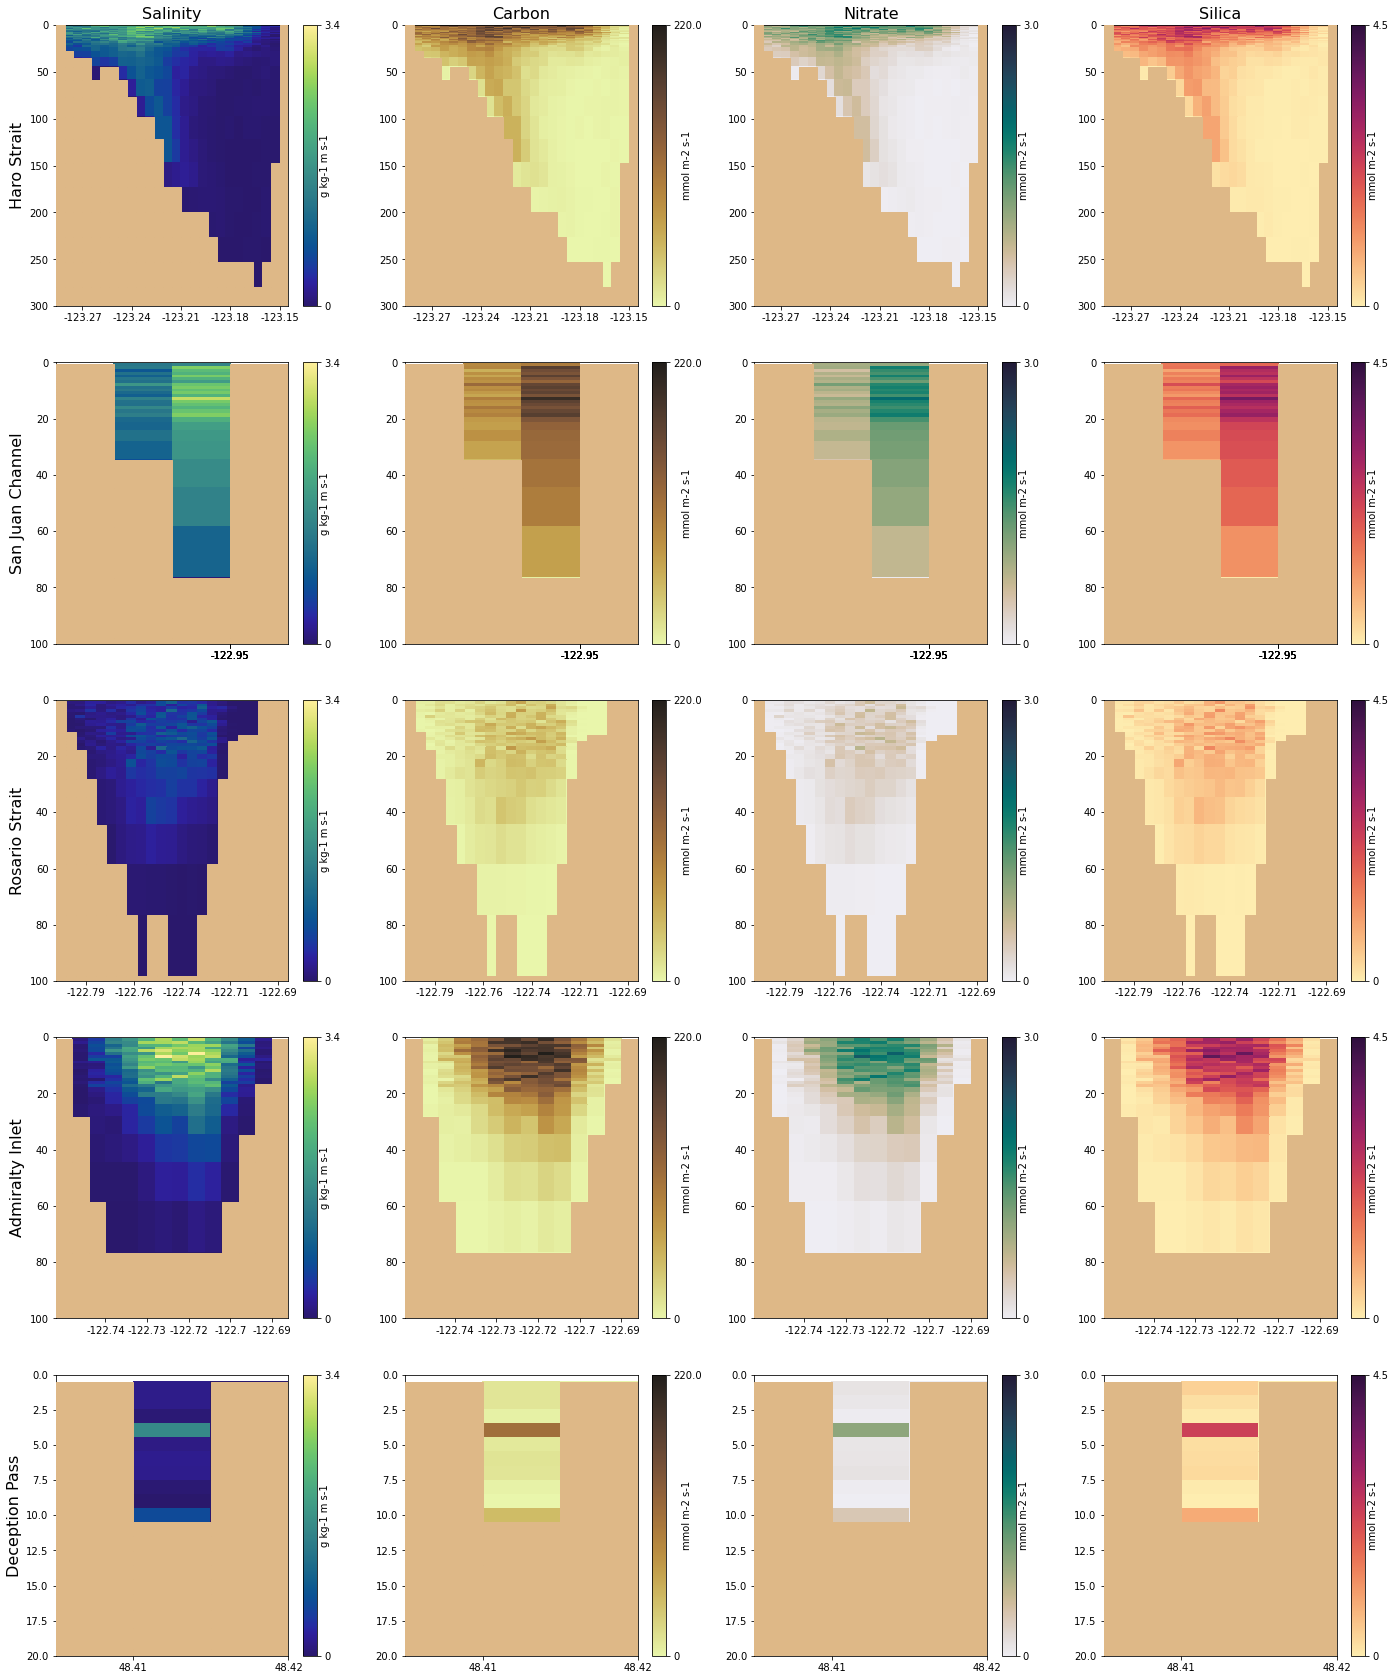

In [19]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

## Forwards run (from JDF to these straits)

In [20]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01mar19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01mar19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

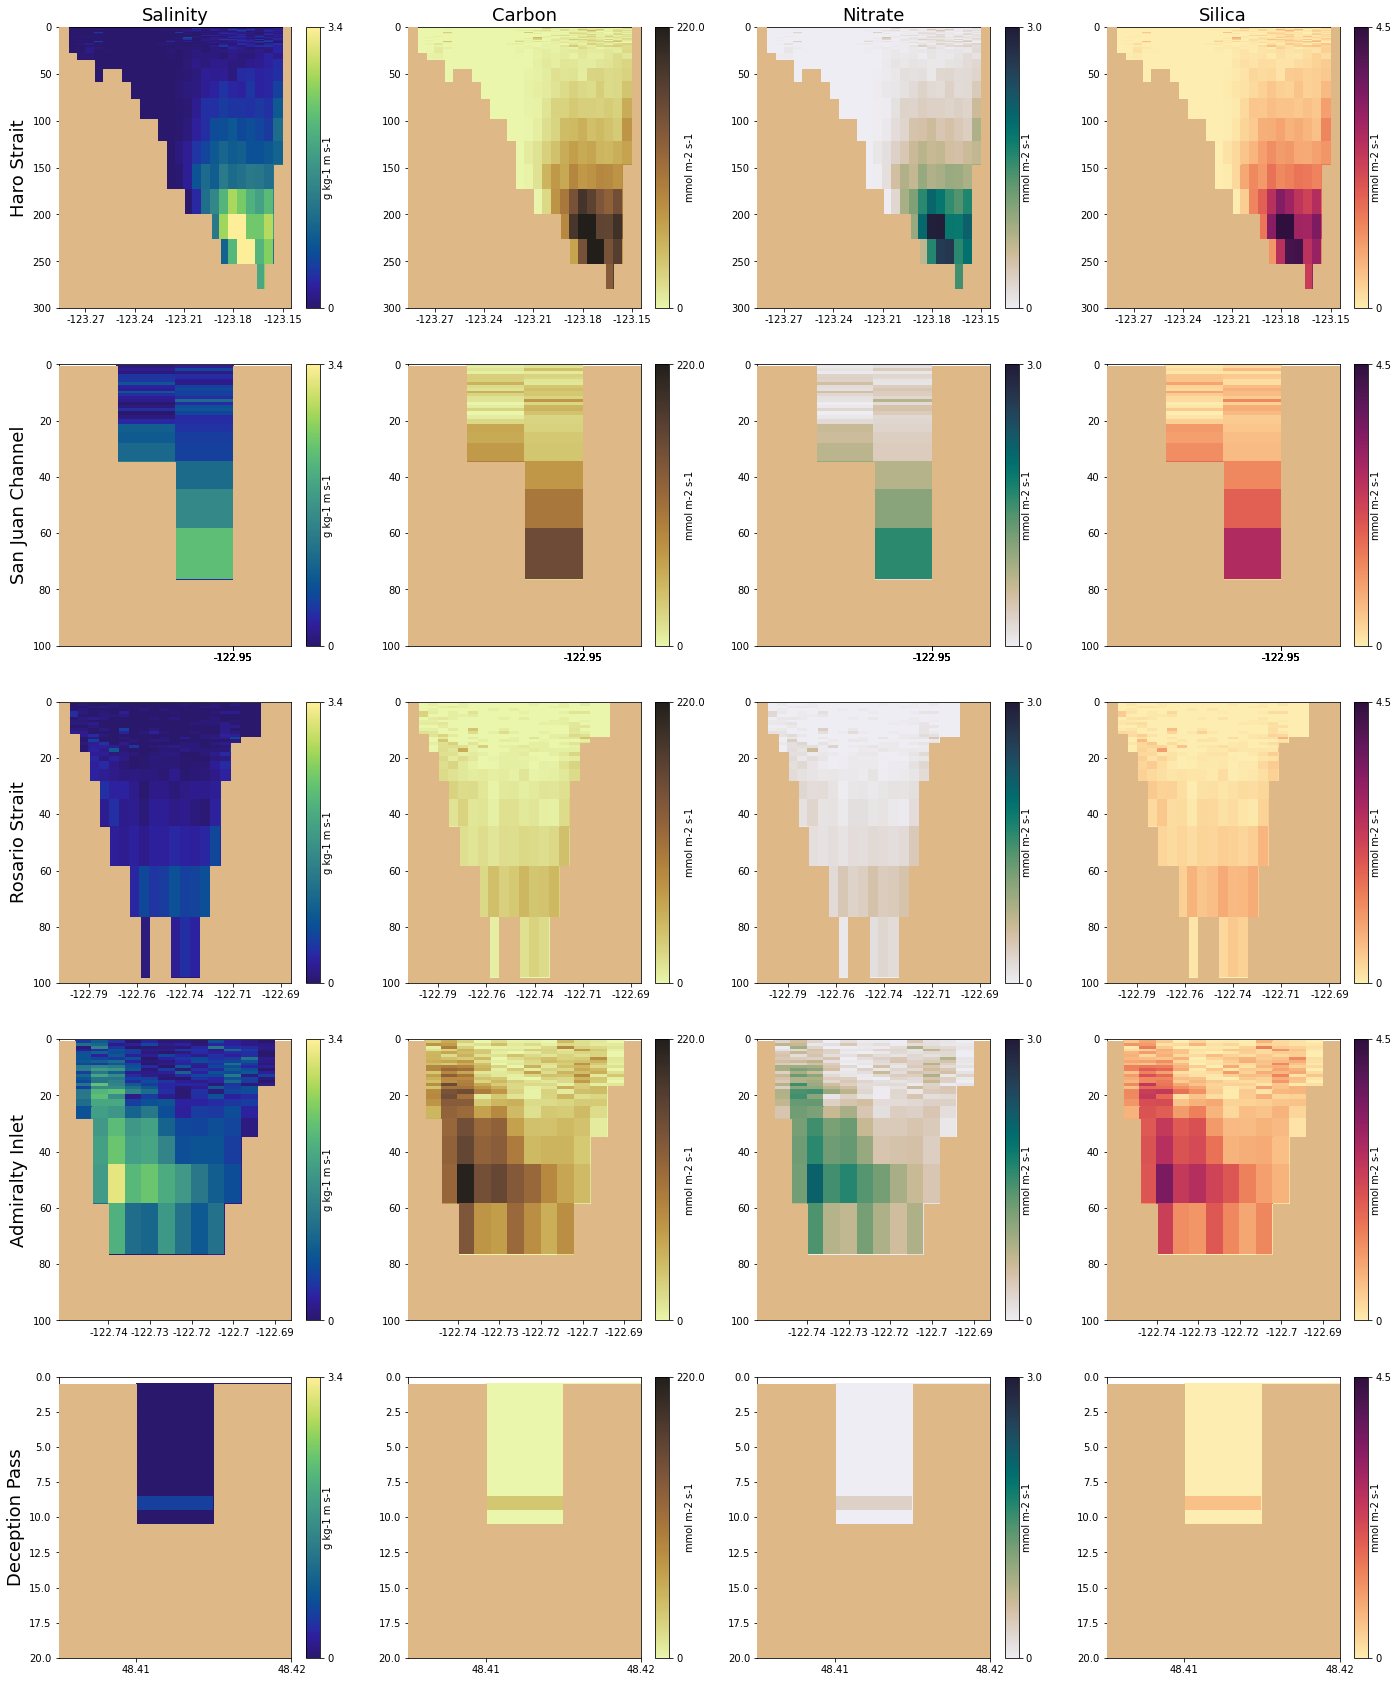

In [21]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

# June
## Backwards run (source water, going from strait in title to the JDF)

In [28]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_01jul19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/backward_01jul19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

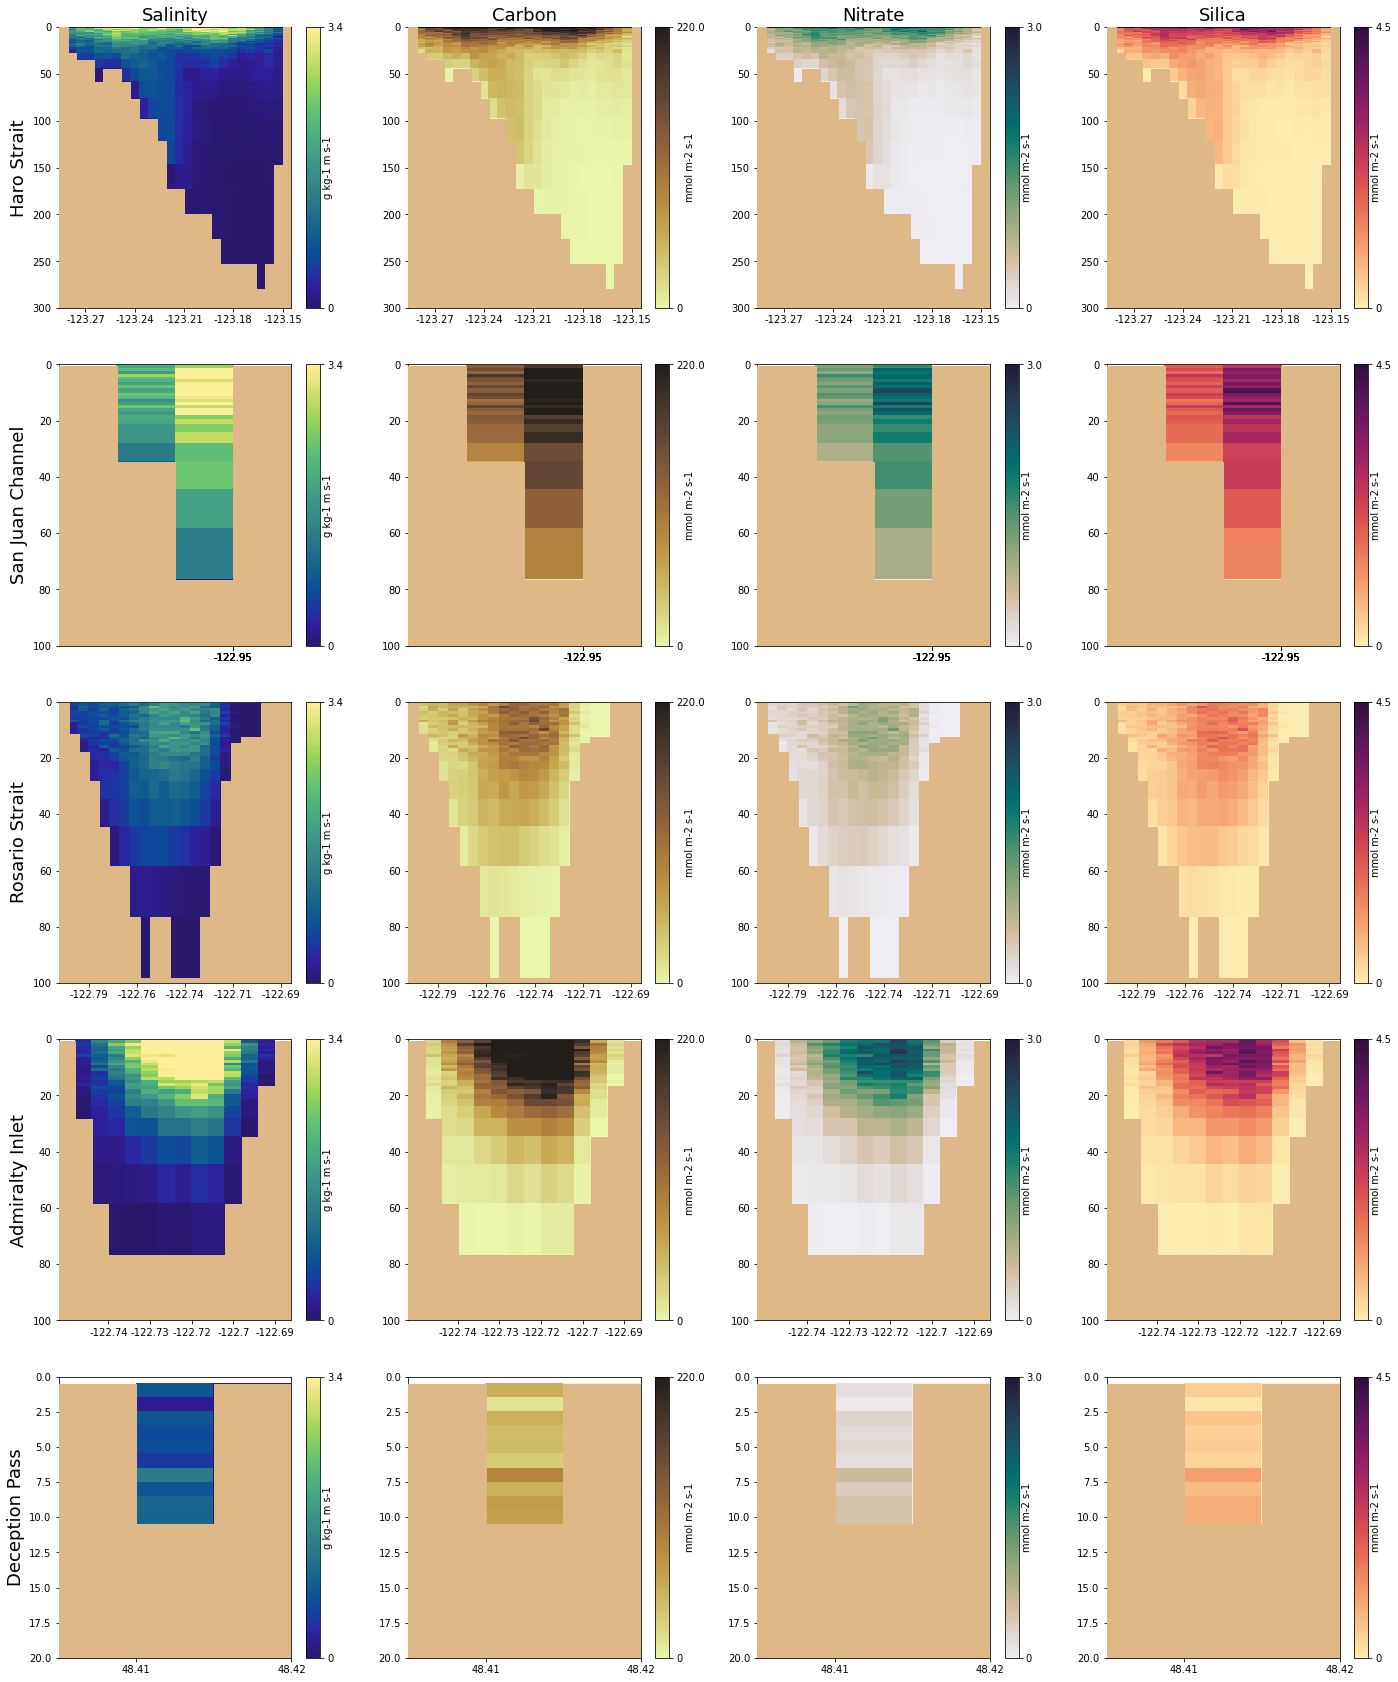

In [29]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

## Forwards run (from JDF to these straits)

In [30]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jun19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01jun19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

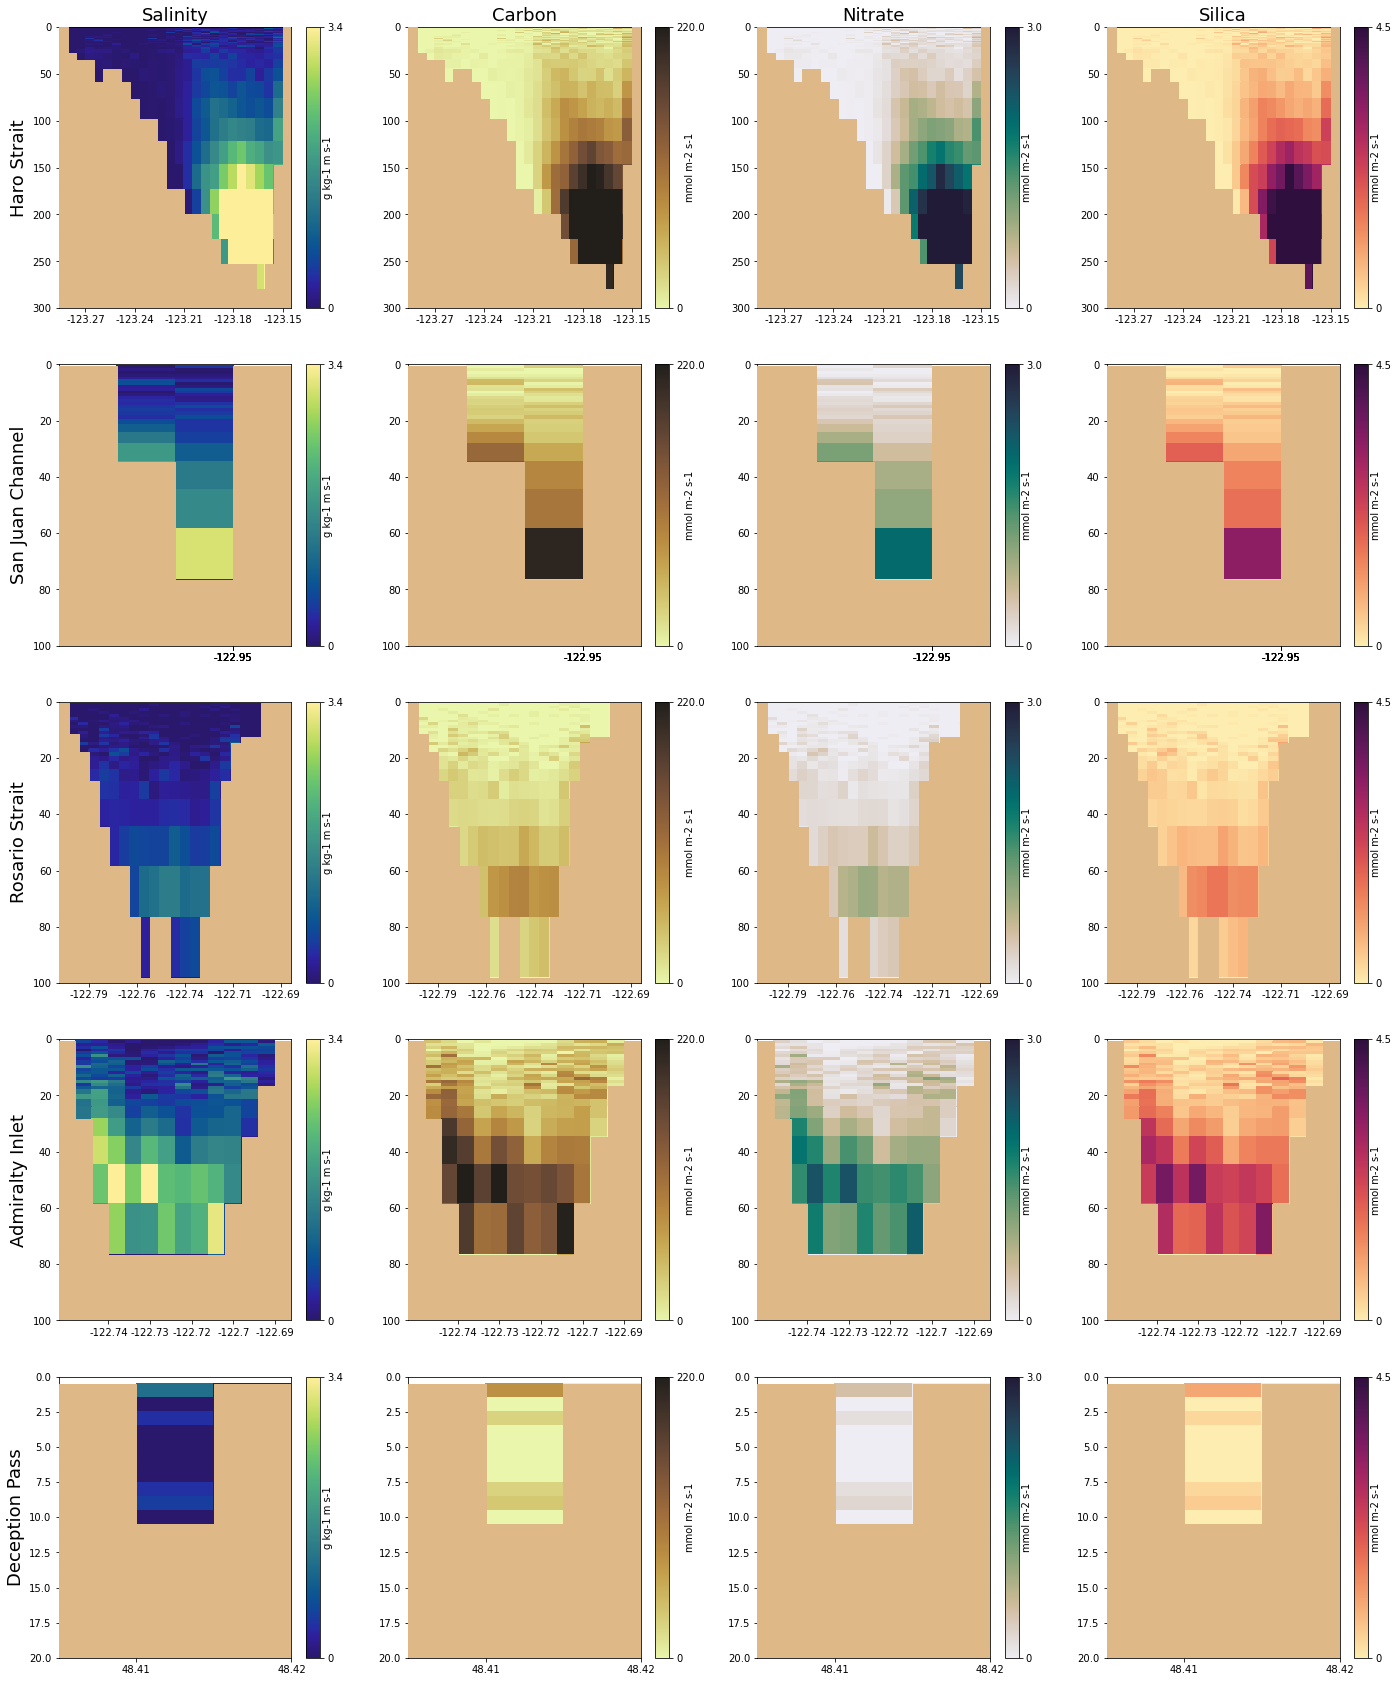

In [31]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

# September
## Backwards run (source water, going from strait in title to the JDF)

In [32]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_01oct19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/backward_01oct19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

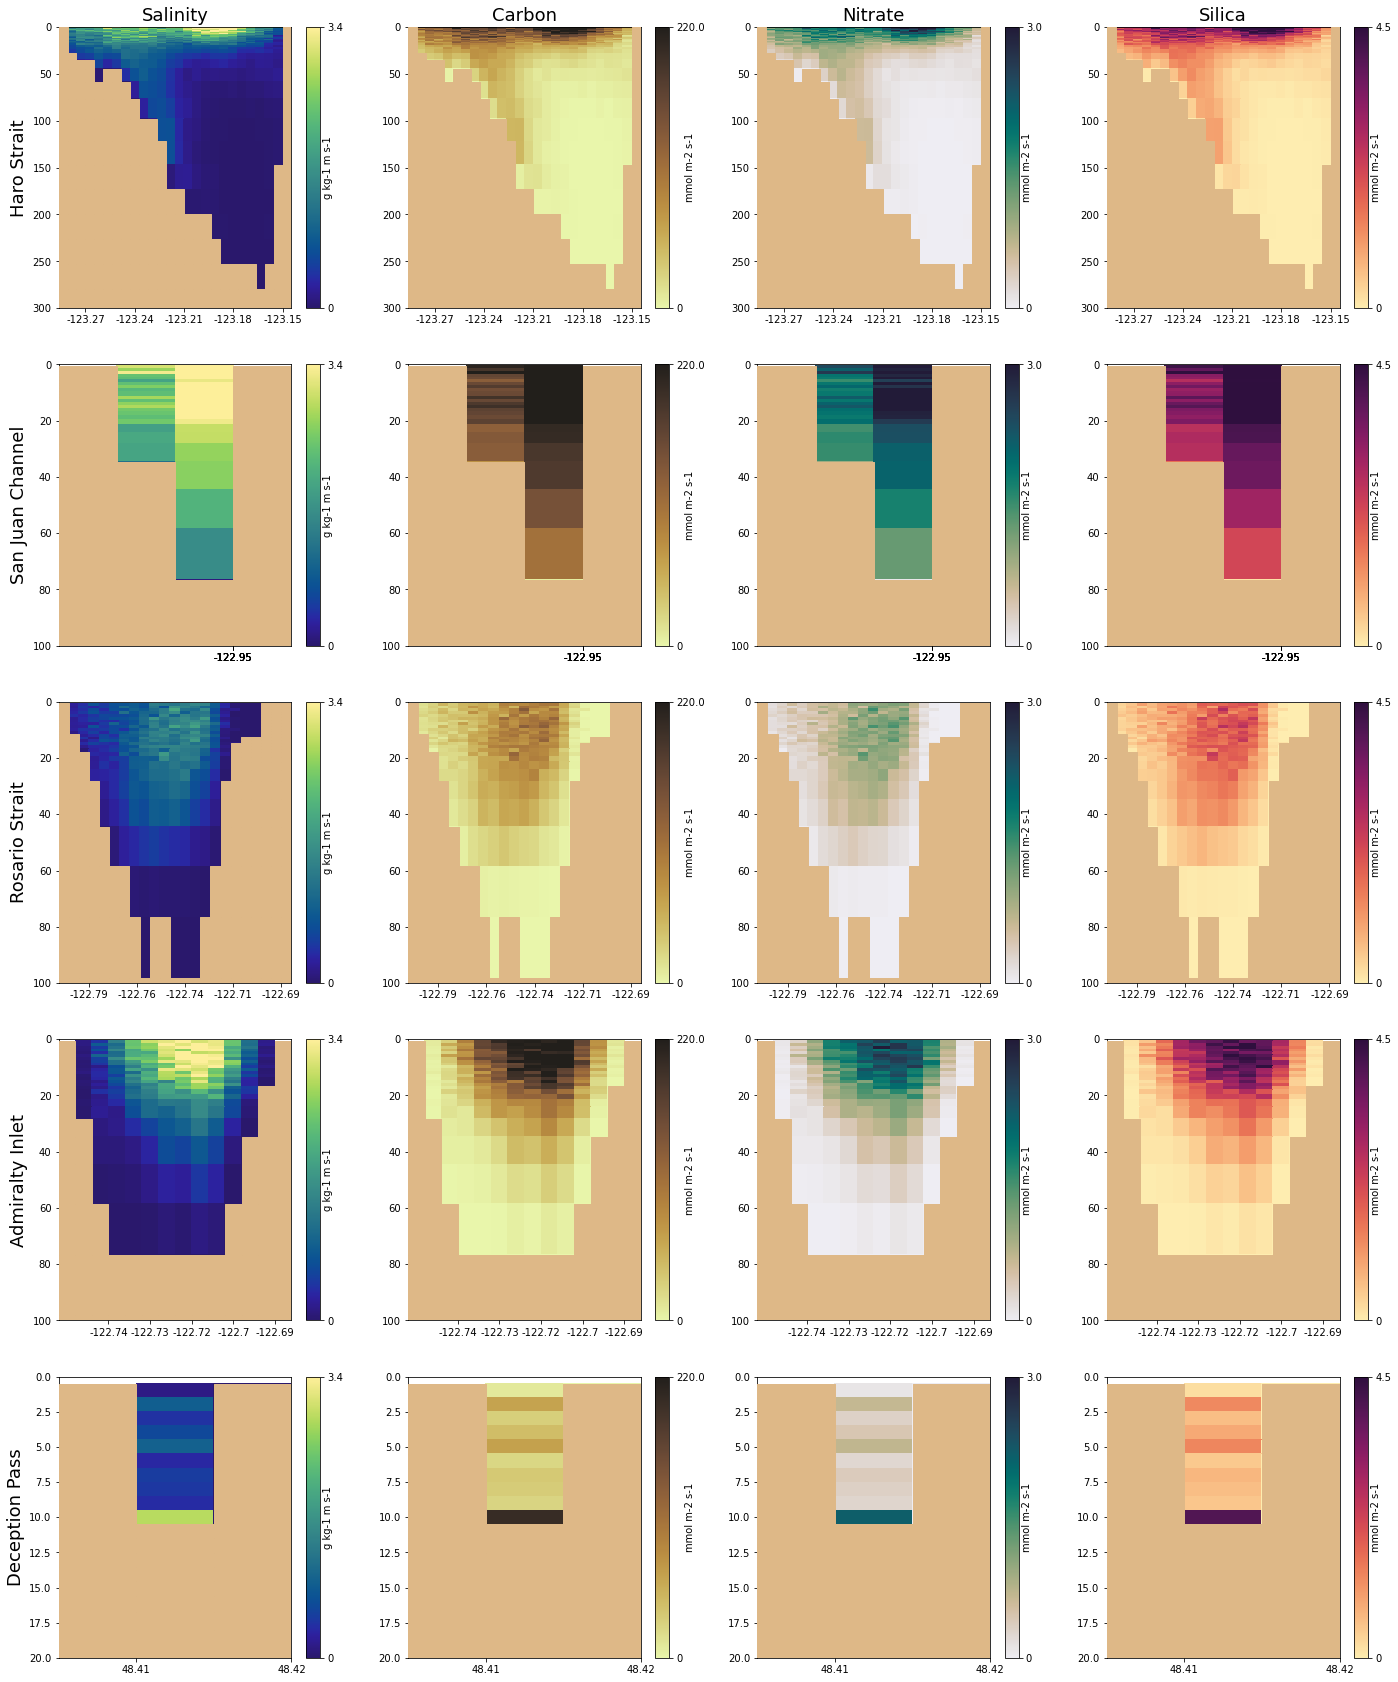

In [33]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

## Forwards run (from JDF to these straits)

In [34]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01sep19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01sep19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

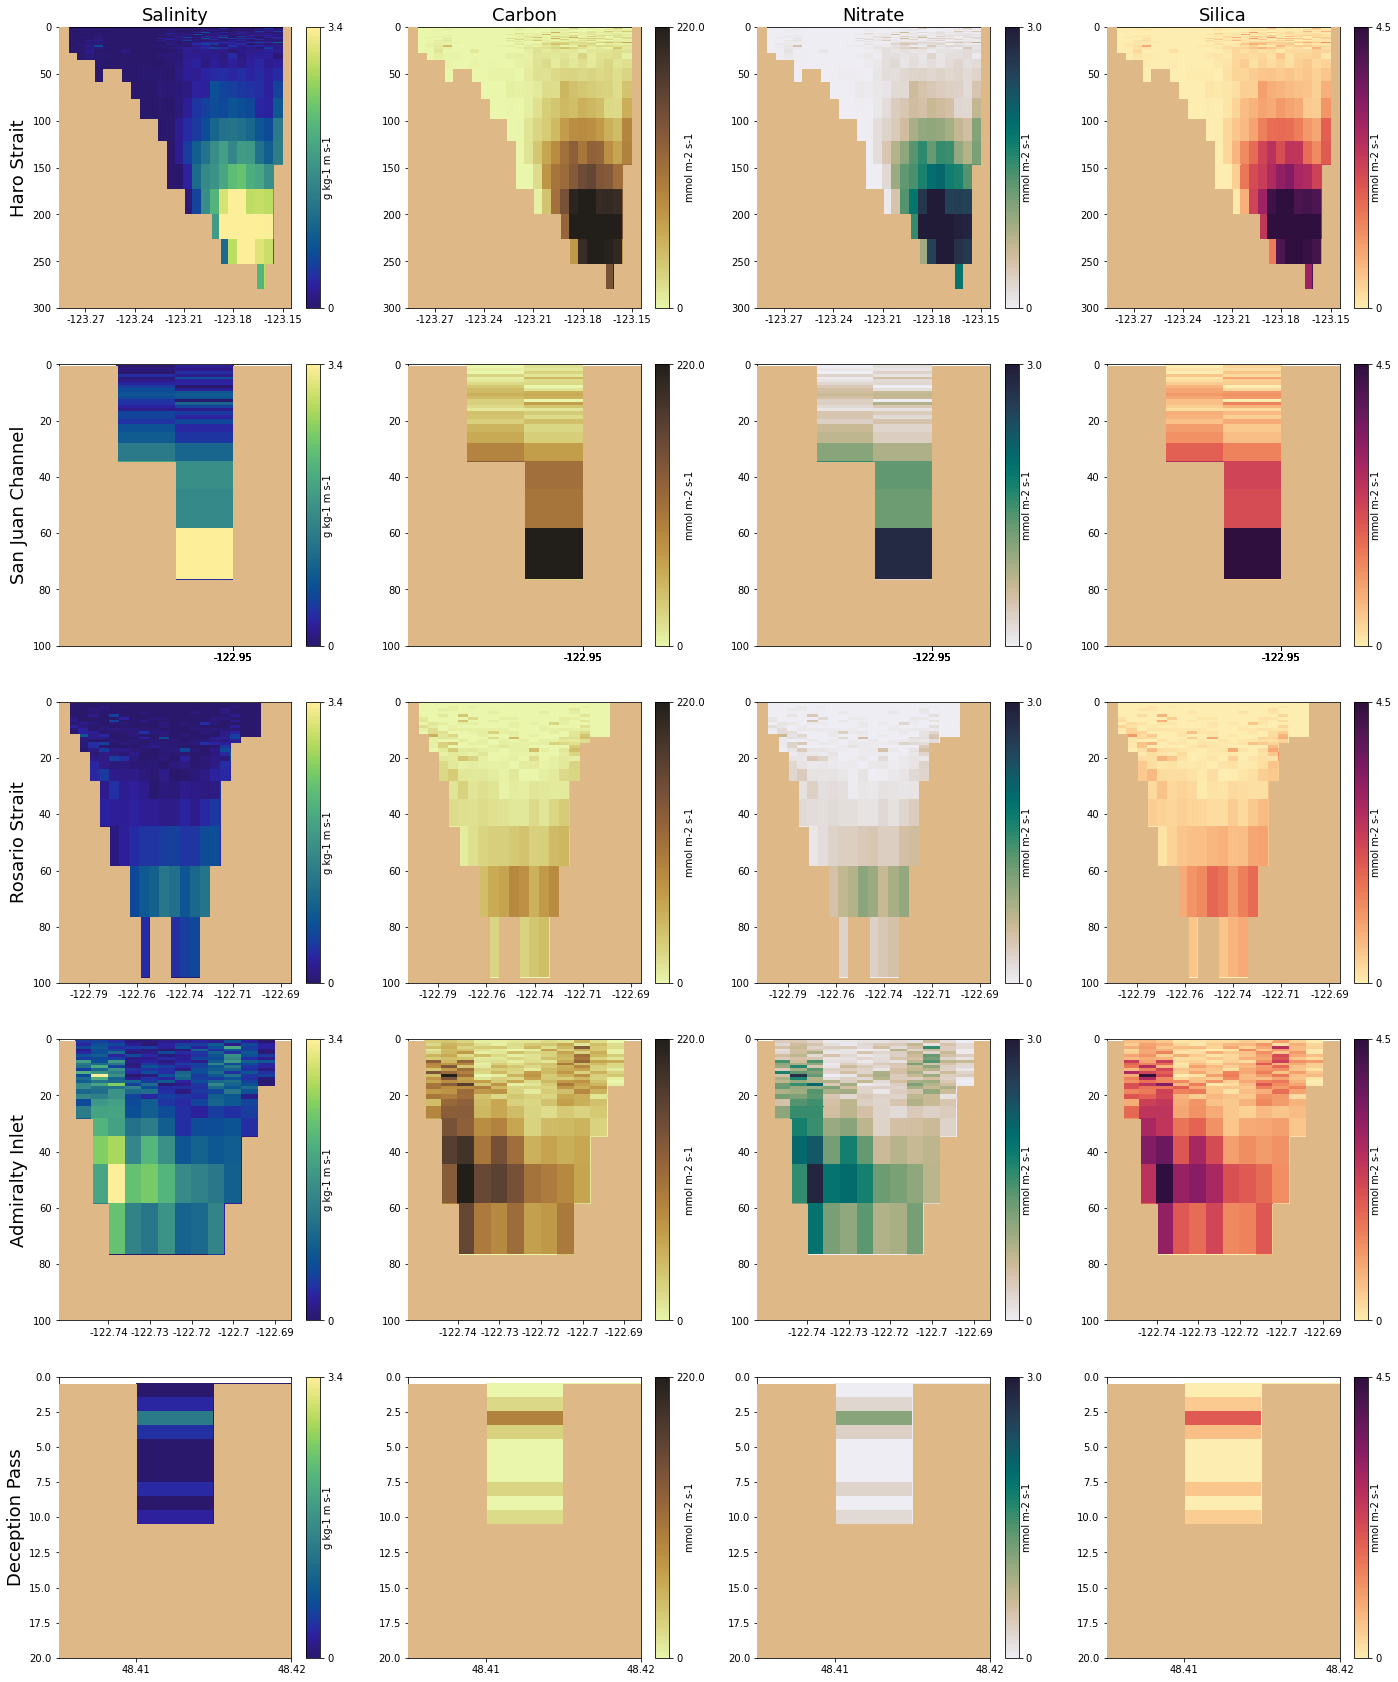

In [35]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

# December
## Backwards run (source water, going from strait in title to the JDF)

In [36]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_31dec19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/backward_31dec19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

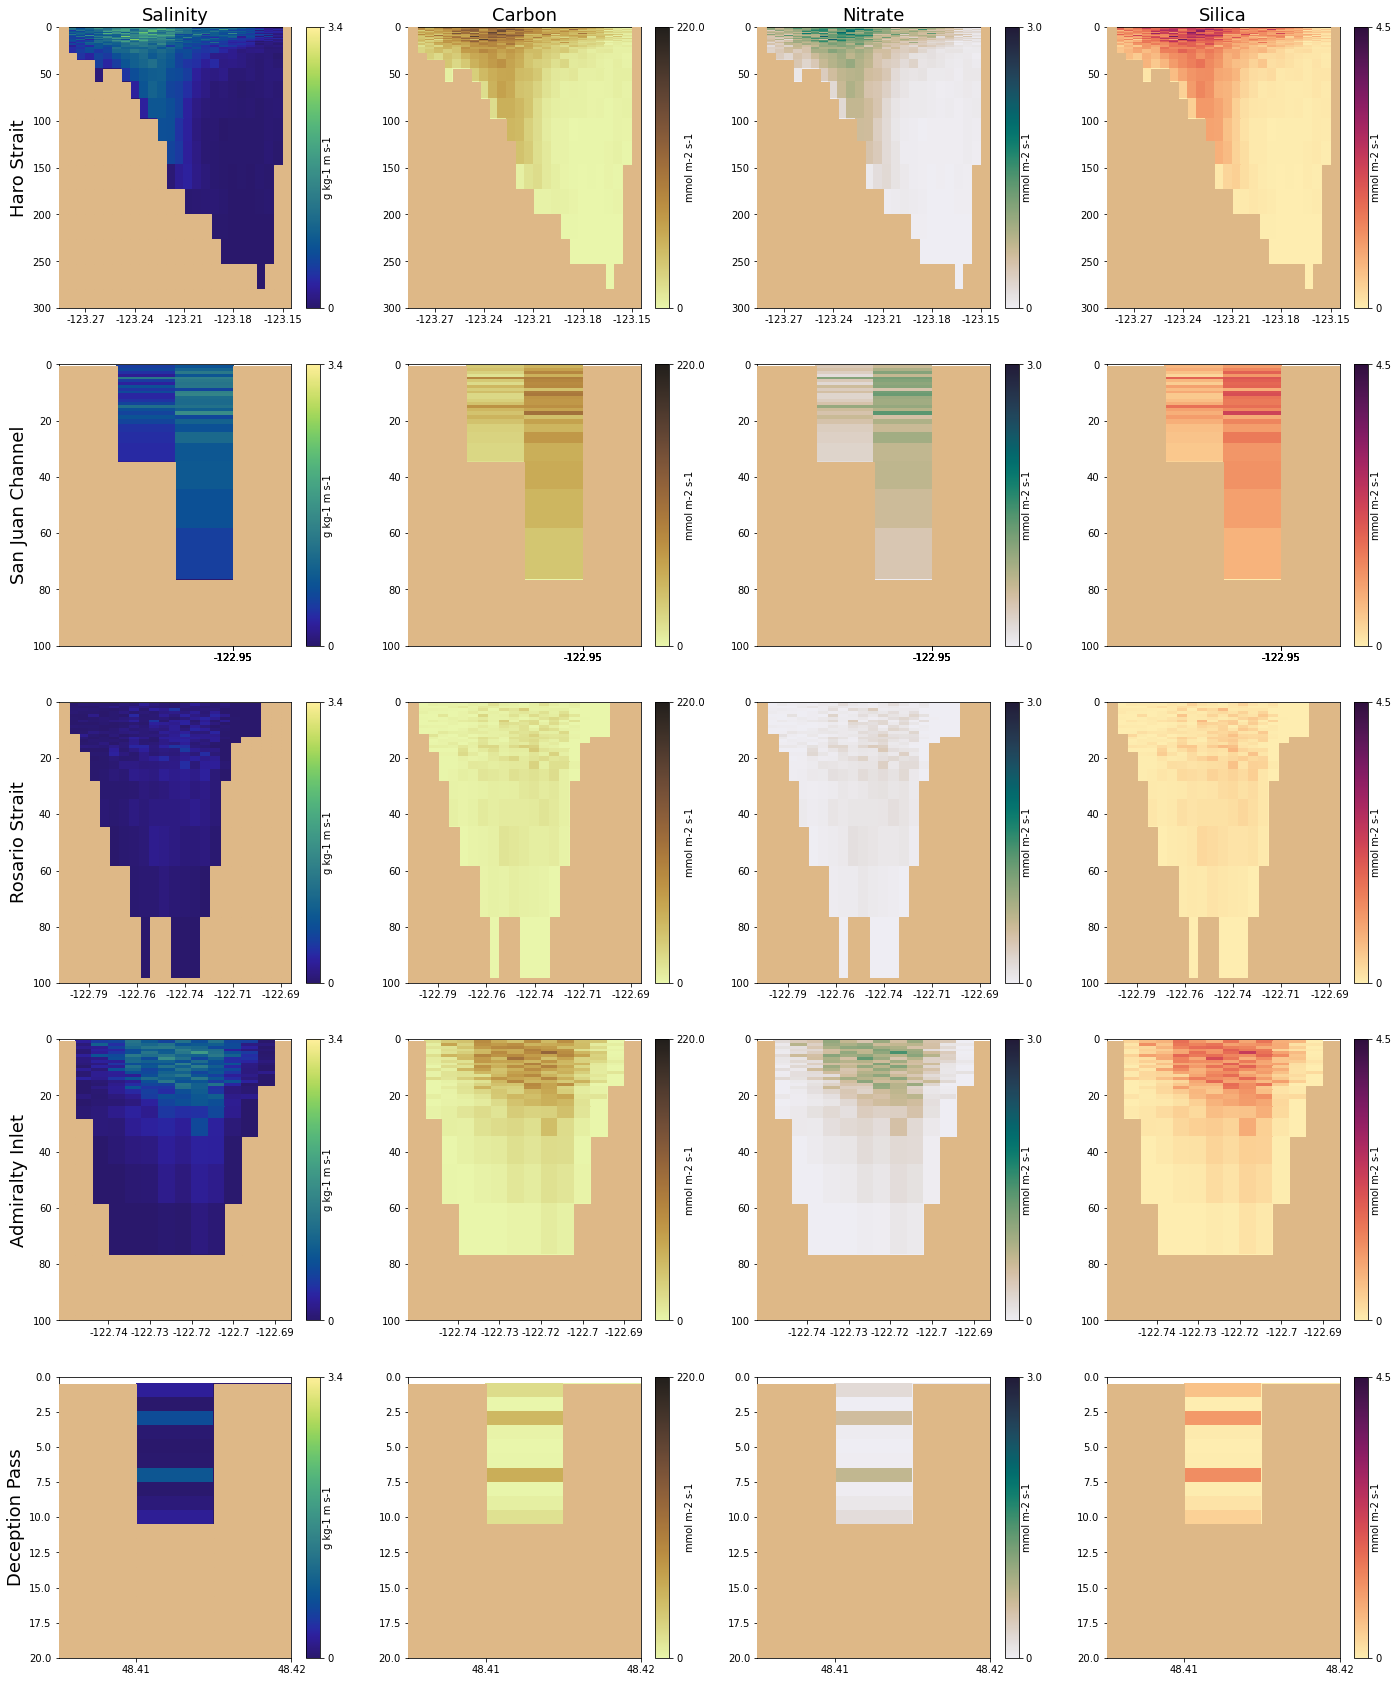

In [37]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)

## Forwards run (from JDF to these straits)

In [38]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01dec19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01dec19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

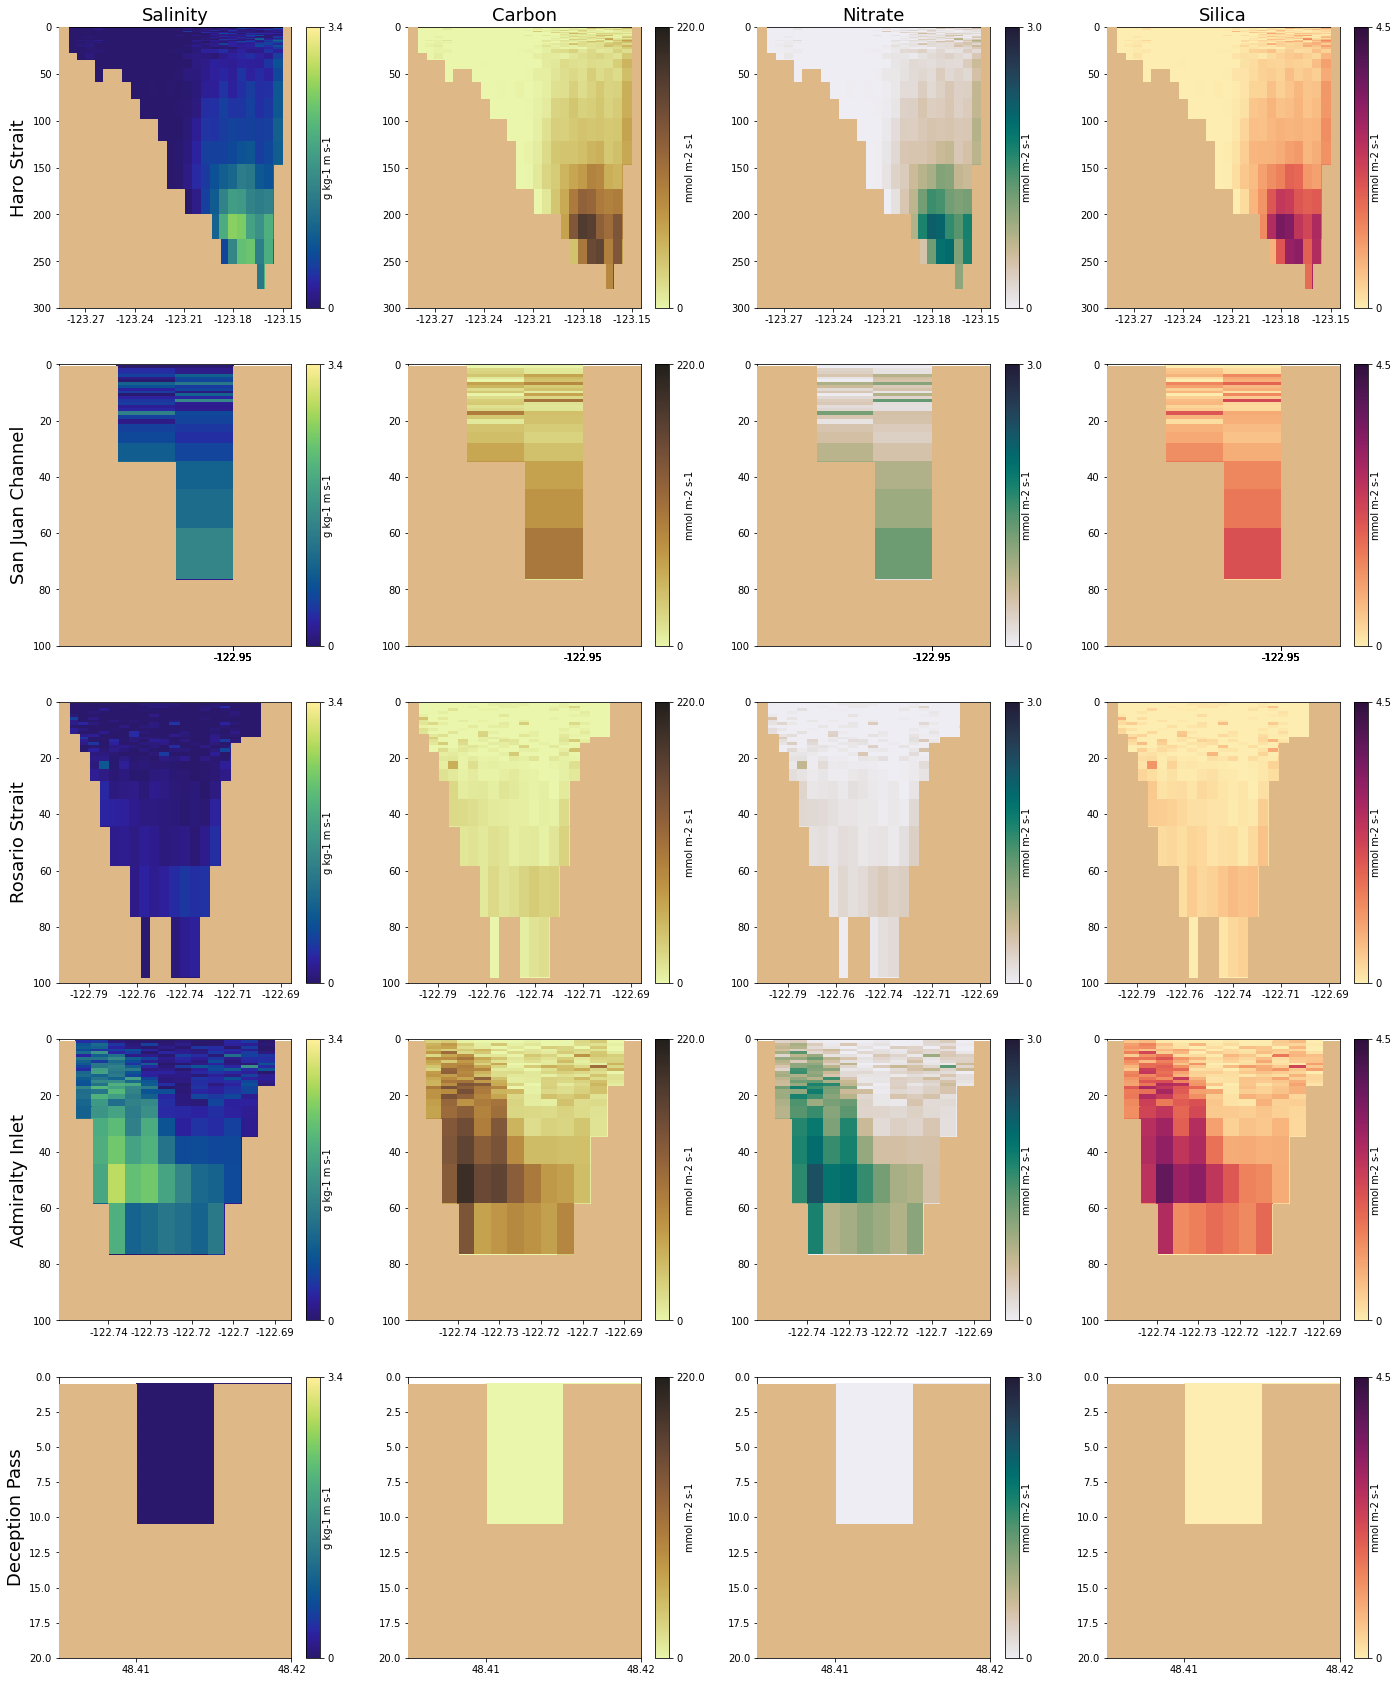

In [39]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
saltFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
carbonFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
nitrateFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
siliconFluxCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

saltFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
carbonFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
nitrateFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
siliconFluxCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

saltFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
carbonFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
nitrateFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
siliconFluxCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

saltFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
carbonFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
nitrateFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
siliconFluxCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DsaltFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DcarbonFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DnitrateFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DsiliconFluxCS(decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 18)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 18)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 18)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 18)
axs[4,0].set_ylabel('Deception Pass', fontsize = 18)
axs[0,0].set_title('Salinity', fontsize = 18)
axs[0,1].set_title('Carbon', fontsize = 18)
axs[0,2].set_title('Nitrate', fontsize = 18)
axs[0,3].set_title('Silica', fontsize = 18)